# Create data

In [1]:
import pandas as pd
from tqdm import tqdm

In [6]:
df = pd.concat(
    [
        pd.read_csv('../data/hw_2/validation/train', sep=',', header=None),
        pd.read_csv('../data/hw_2/validation/test', sep=',', header=None)
    ],
    ignore_index=False
)

user, item, order = list(), list(), list()

for idx in tqdm(range(df.shape[0])):
    curr_items = [int(item) for item in df[0].iloc[idx].split()]
    user.extend([idx for _ in curr_items])
    item.extend(curr_items)
    order.extend([like for like in reversed(range(len(curr_items)))])

df = pd.DataFrame(
    {
        'user': user,
        'item': item,
        'order': order
    }
)

df.to_csv('../data/hw_2/validation/data_for_task.csv', index=False)

# Validation

In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import pandas as pd

from service.utils.validation_strategy import UsersKFoldPOut

In [3]:
df = pd.read_csv('../data/hw_2/validation/data_for_task.csv')

In [4]:
P = 15
N_FOLD = 3

In [5]:
cv = UsersKFoldPOut(n_folds=N_FOLD, p=P)

for i, (train_mask, test_mask) in enumerate(cv.split(df)):
    train = df[train_mask]
    test = df[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 62769950, Test: 5342919
Fold#1 | Train: 62749697, Test: 5344940
Fold#2 | Train: 62857621, Test: 5342556


**Проанализируем заключительный Fold**

In [6]:
train

,user,item,order
54,1,174197,9
55,1,335779,8
56,1,141676,7
57,1,119856,6
58,1,376664,5
...,...,...,...
94188373,1160082,278375,4
94188374,1160082,399255,3
94188375,1160082,7045,2
94188376,1160082,287708,1


In [7]:
test

,user,item,order
39,0,170753,14
40,0,432424,13
41,0,330581,12
42,0,63471,11
43,0,424658,10
...,...,...,...
94188629,1160083,80233,4
94188630,1160083,369632,3
94188631,1160083,46592,2
94188632,1160083,408275,1


In [10]:
test

,user,item,order
39,0,170753,14
40,0,432424,13
41,0,330581,12
42,0,63471,11
43,0,424658,10
...,...,...,...
94188629,1160083,80233,4
94188630,1160083,369632,3
94188631,1160083,46592,2
94188632,1160083,408275,1


In [8]:
users_train = train['user'].unique()
users_test = test['user'].unique()
np.setdiff1d(users_test, users_train).shape[0] == users_test.shape[0]

True

In [12]:
test[test['order'] > P].shape[0] == 0

True

# Metrics

In [274]:
from time import monotonic

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import numba as nb
from tqdm import tqdm

## Mean Reciptrocal Rank

In [6]:
df = pd.read_csv('../data/kion_train/interactions.csv')
df.rename(
    columns={
        'user_id': 'user',
        'item_id': 'item'
    },
    inplace=True
)
del df['last_watch_dt'], df['total_dur'], df['watched_pct']
df

,user,item
0,176549,9506
1,699317,1659
2,656683,7107
3,864613,7638
4,964868,9506
...,...,...
5476246,648596,12225
5476247,546862,9673
5476248,697262,15297
5476249,384202,16197


In [13]:
def generate_subsample(df, users_count, top_k):
    users = np.random.choice(df['user'].unique(), users_count, replace=False)
    df_return = df[df['user'].isin(users)].reset_index(drop=True)

    recs = np.random.choice(df_return['item'], size=(users_count, top_k))
    return df_return, users, recs

In [200]:
def mrr_naive(target, users, recs, k):
    mrr = []
    for idx_user, user in enumerate(users):
        sum_invers_rank = 0
        user_target = target[target[:, 0] == user][:, 1]
        for idx_rec, rec in enumerate(recs[idx_user], start=1):
            if rec in user_target:
                sum_invers_rank = 1 / idx_rec
                break
        mrr.append(sum_invers_rank)
    return sum(mrr) / len(users)


@nb.njit(cache=True, parallel=True, nopython=False)
def mrr_numba(target, users, recs, k):
    mrr = np.zeros(len(users))
    for idx_user in nb.prange(len(users)):
        user = users[idx_user]
        sum_invers_rank = 0
        user_target = target[target[:, 0] == user][:, 1]
        for idx_rec in nb.prange(len(recs[idx_user])):
            if recs[idx_user][idx_rec] in user_target:
                sum_invers_rank += 1 / (idx_rec + 1)
                break
        mrr[idx_user] = sum_invers_rank
    return mrr.mean()


def mrr_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
            'user': np.repeat(users, k),
            'item': recs.ravel()
    })
    df_recs['rank'] = df_recs.groupby('user').cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=['user', 'item'], right_on=['user', 'item'])
    tp_k = f'TP@{k}'
    df_recs[tp_k] = df_recs['rank'] < (k + 1)
    if df_recs[df_recs[tp_k] == True].shape[0] > 0:
        p = sum(1 / df_recs[df_recs[tp_k] == True].groupby('user')['rank'].agg('min')) / len(users)
    else:
        p = 0
    return p

/home/mlandrey/PycharmProjects/ITMO/RecSys_MTC/RecoServiceTemplate/.venv/lib/python3.8/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [202]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
all_values = dict()
for user_count in users_count:
    for k in top_k:
        all_values[f'{user_count}_{k}'] = generate_subsample(df, user_count, k)

In [218]:
algorithm, time, user_count_values, top_k_values = [], [], [], []
for user_count in tqdm(users_count):
    for k in top_k:
        curr_df, curr_users, curr_recs = all_values[f'{user_count}_{k}']

        strat_time = monotonic()
        mrr_naive(curr_df.values, curr_users, curr_recs, k)
        time.append(monotonic() - strat_time)
        algorithm.append('naive')
        user_count_values.append(user_count)
        top_k_values.append(k)

        strat_time = monotonic()
        mrr_numba(curr_df.values, curr_users, curr_recs, k)
        time.append(monotonic() - strat_time)
        algorithm.append('numba')
        user_count_values.append(user_count)
        top_k_values.append(k)

        strat_time = monotonic()
        mrr_pandas(curr_df, curr_users, curr_recs, k)
        time.append(monotonic() - strat_time)
        algorithm.append('pandas')
        user_count_values.append(user_count)
        top_k_values.append(k)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:31<00:00, 112.82s/it]


In [224]:
df_result = pd.DataFrame(
    {
        "algorithm": algorithm,
        "time": time,
        "user_count": user_count_values,
        "top_k": top_k_values
    }
)

df_result

,algorithm,time,user_count,top_k
0,naive,0.002719,100,10
1,numba,0.009204,100,10
2,pandas,0.005075,100,10
3,naive,0.009850,100,50
4,numba,0.019756,100,50
5,pandas,0.005876,100,50
6,naive,0.014653,100,100
7,numba,0.011318,100,100
8,pandas,0.006229,100,100
9,naive,0.032738,1000,10


In [225]:
df_result.to_csv('../data/hw_2/metrics/results_mrr.csv', index=False)

/tmp/ipykernel_8667/1460943707.py:23: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/tmp/ipykernel_8667/1460943707.py:24: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/tmp/ipykernel_8667/1460943707.py:25: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



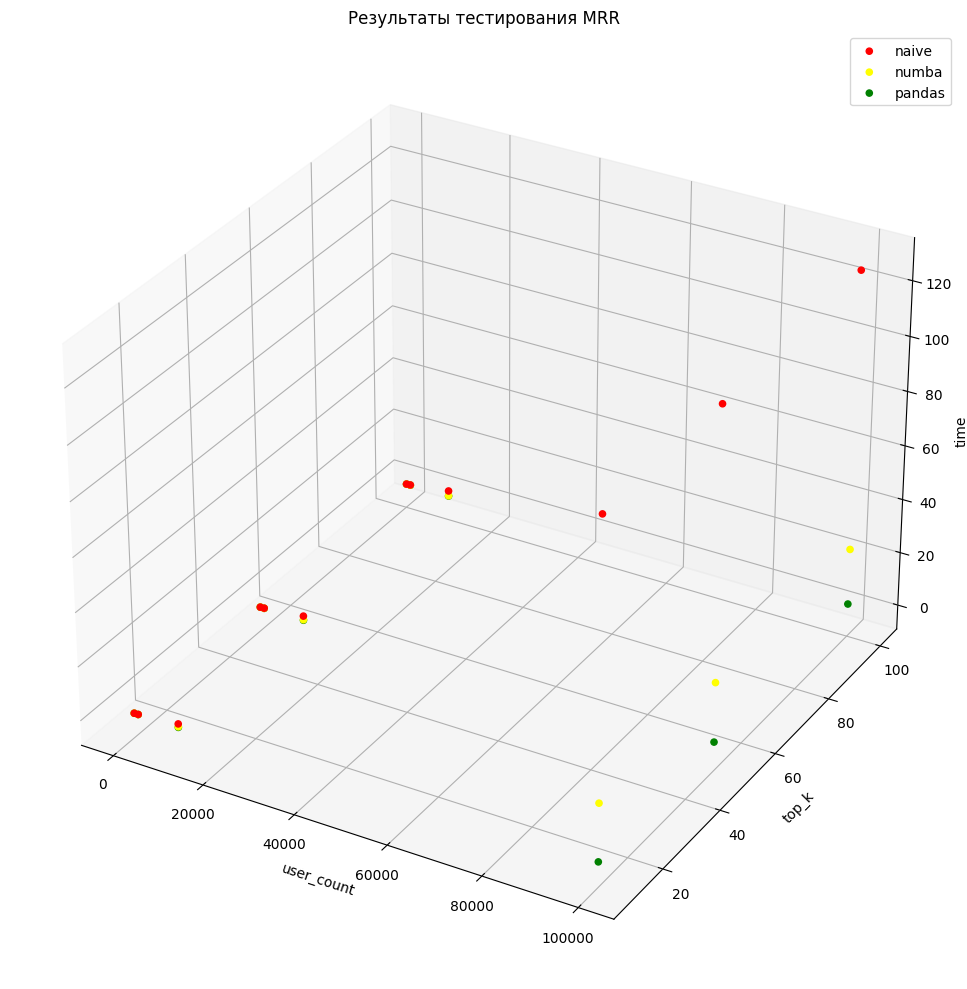

In [273]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 = df_result[df_result['algorithm']=='naive']['user_count']
y1 = df_result[df_result['algorithm']=='naive']['top_k']
z1 = df_result[df_result['algorithm']=='naive']['time']
c1 = df_result[df_result['algorithm']=='naive']['algorithm'].replace({'naive': 'red'})

x2 = df_result[df_result['algorithm']=='numba']['user_count']
y2 = df_result[df_result['algorithm']=='numba']['top_k']
z2 = df_result[df_result['algorithm']=='numba']['time']
c2 = df_result[df_result['algorithm']=='numba']['algorithm'].replace({'numba': 'yellow'})

x3 = df_result[df_result['algorithm']=='pandas']['user_count']
y3 = df_result[df_result['algorithm']=='pandas']['top_k']
z3 = df_result[df_result['algorithm']=='pandas']['time']
c3 = df_result[df_result['algorithm']=='pandas']['algorithm'].replace({'pandas': 'green'})

ax.scatter(x1, y1, z1, c=c1, cmap='YlOrRd', alpha=1)
ax.scatter(x2, y2, z2, c=c2, cmap='YlOrRd', alpha=1)
ax.scatter(x3, y3, z3, c=c3, cmap='YlOrRd', alpha=1)
ax.set_xlabel('user_count')
ax.set_ylabel('top_k')
ax.set_zlabel('time', rotation='vertical')
ax.set_title('Результаты тестирования MRR')
ax.legend(['naive', 'numba', 'pandas'])
plt.show();

# PFound